#### Import

In [14]:
from frozen_yoghourt import *

### Problem Statement

We theorize the following architecture for building $n$-Toffoli modulo phase shift in linear complexity. For $n>2$, a circuit of $n+1$ qubits employs $2n+1$ parameterized unitary matrices. This makes $n$ the number of control bits. Below is an example of a 5 qubits circuit that uses 9 parameterized unitary matrices.

<img src="circuit.png" width="800" height="800" align="left"/>

The parameterized matrices being used here are the standard $U3$ matrices with $3$ parameters $\theta, \phi, \lambda$, where each gate has its own set of parameters

$$U_i = \begin{align} U(\theta_i, \phi_i, \lambda_i) = \begin{pmatrix} \cos\left(\frac{\theta_i}{2}\right) & -e^{i\lambda_i}\sin\left(\frac{\theta_i}{2}\right) \\ e^{i\phi_i}\sin\left(\frac{\theta_i}{2}\right) & e^{i(\phi+\lambda)}\cos\left(\frac{\theta_i}{2}\right) \end{pmatrix}
\end{align}$$

From now on, we will short hand the trigonometric functions

$$\cos\Big{(}{\frac{\theta_i}{2}}\Big{)} \rightarrow c_i$$

$$\sin\Big{(}{\frac{\theta_i}{2}}\Big{)} \rightarrow s_i$$

Now, looking strictly at the values in the output qubits, where $x$ is the input of the circuit such that $x\in \{0, 1\}^n$, for which $x_j$ represents the input in the $j$th qubit. 

Let $A$ be a set that contains the index of the control bits of the $CX$ gates in the same order as the circuit.

$$A = \{n+1, 0, 1, ..., n, 0, 1, ..., n+1\}$$

Note that $A[0] = n+1$ and $|A| = 2n$.

We are asked to find the unique values $\theta_n, \phi_n, \lambda_n$ for each single qubit unitary matrix $U_n$. For binary inputs, the circuit that satisfy the following equality

$$\big{|}U_{2n} \Big{(}\prod_{i=2n-1}^{0} \rho_i U_{i} \Big{)} \big{|}= \big{(}\bigwedge_{i=0}^{n-1} x_{A[i]}\big{)} X + \big{(}1 - \bigwedge_{i=0}^{n-1} x_{A[i]}\big{)} I $$

where $\rho_i = (x_{A[i]} X + (1-x_{A[i]}) I)$, and $|M|$ denotes taking the absolute value of all the elements in each column of the matrix. This helps negate the effect of modulo phase shift outputs. For example,

$$\Big{|} \ \begin{pmatrix} e^{i\theta}r_0 & e^{i\phi}r_1 \\ e^{i\theta}r_2 & e^{i\phi}r_3 \end{pmatrix}\Big{|} = \begin{pmatrix} r_0 & r_1 \\ r_2 & r_3 \end{pmatrix}$$



For all the $2^n$ possible binary inputs, we have the equality

$$LHS = X \iff \bigwedge_{i=0}^{n-1} \rho_i = 1$$ 

###### Example of $n=3$

For $n = 3$, we have the below circuit

<img src="work_example.png" width="800" height="800" align="left"/>

There are $21$ variables defined by the set $\{\theta_i, \phi_i, \lambda_i\}_{i|=0}^{6}$. There are also $8$ systems of equations, one for each binary input. 

$$\begin{align} 000&:|U_6 U_5 U_4 U_3 U_2 U_1 U_0 |= I \\ 001 &:| U_6 U_5 U_4  \ (X) \  U_3 U_2  \ (X) \  U_1 U_0 |= I \\ 010 &:|U_6 U_5  \ (X) \  U_4 U_3  \ (X) \  U_2 U_1 U_0 |= I \\ 011 &:|U_6 U_5  \ (X) \  U_4  \ (X) \  U_3  \ (X) \  U_2  \ (X) \  U_1 U_0 |= I \\ 100 &:|U_6  \ (X) \  U_5 U_4 U_3 U_2 U_1  \ (X) \  U_0 |= I \\ 101 &:|U_6  \ (X) \  U_5  \ (X) \  U_4 U_3 U_2  \ (X) \  U_1  \ (X) \  U_0 |= I \\ 110&:|U_6  \ (X) \  U_5  \ (X) \  U_4 U_3  \ (X) \  U_2 U_1  \ (X) \  U_0 |= I \\ 111&:|U_6  \ (X) \  U_5  \ (X) \  U_4  \ (X) \  U_3  \ (X) \  U_2  \ (X) \  U_1  \ (X) \  U_0 |= X \end{align}$$

### Method of Parameters Search

The parameters of the unitary matrices are searched numerically using gradient descent method. This is done throug the use of a cost function, which indicates the "closeness" between the prediction using the model and the actual value. Then by using the partial derivative of this cost function with respect to a certain parameters, we can update that parameters to reduce the cost accordingly. The gradient descent method outlined below is made up of $4$ steps.

1. Forward Propagation
2. Cost Calculation
3. Backward Propagation
4. Parameters Update

#### 1. Forward Propagation Network

The network of the forward propagation steps is made up of $2n+1$ layers. Each layers consisting of $3$ parameters $\theta, \phi \lambda$. The general network is represented by the diagram below, where $x$ is the $(2, 1)$ column vector input, and $\hat{y}$ is the $(2, 1)$ column vector output of the network.

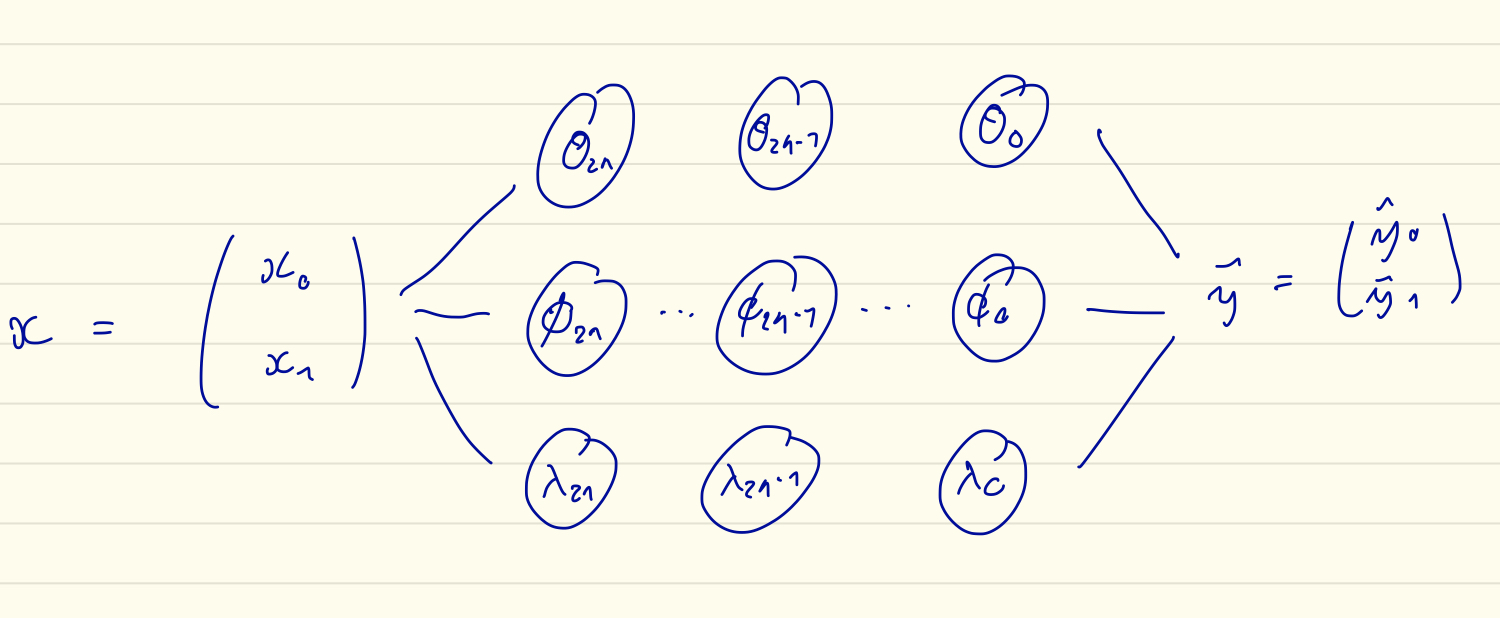

Note that all the parameters of one layers are connected to all of the parameters of the next layers through the multiplication of unitary matrices based on equality $(1)$ from above.

$$\hat{y} = U_{2n} \big{(}\prod_{i=2n-1}^{0} \rho_i U_{i} \big{)} x$$

where, $x$ is a binary input

#### 2. Cost Calculation

For each binary inputs, the output is either $I$ or $X$ modulo phase-shift. Therefore, it is important to find the correct functions that sets an equivalence relations that ignores the global phase (if any) between $\hat{y}$ and $y$. Taking inspiration from existing literature, we build our cost metrics on the single-qubit SWAP test. The implementation of the test is outlined below. 

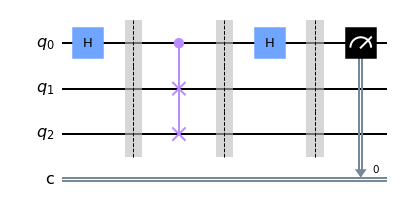

For the circuit above, we use barriers to denotes checkpoints.

Let's call the state in $q_1$, $\delta$ (delta) and $q_2$, $\psi$ (psi). We start with the initial state $|0, \delta, \psi\rangle$.

Recall that $\delta$ is the constant state and $\psi$ is the test state

At the first check point, we apply a Hadamard gate on the first qubit

$$H \ |0, \delta, \psi\rangle = \frac{1}{\sqrt{2}} \ (|0\rangle + |1\rangle) \ |\delta, \psi\rangle = \frac{1}{\sqrt{2}} \ (|0, \delta, \psi\rangle + |1, \delta, \psi \rangle)$$

At the second check point, we apply a control SWAP gate on all three qubits (control: $q_0$, targets: $q_1, q_2$)

$$\text{CSWAP} \frac{1}{\sqrt{2}} \ (|0, \delta, \psi\rangle + |1, \delta, \psi \rangle) = \frac{1}{\sqrt{2}} \ (|0, \delta, \psi \rangle + \underbrace{|1, \psi, \delta \rangle)}_{\delta \text{ and } \psi \text{ is swapped}}$$

At the third check point, we apply another Hadamard on the first qubit on the

$$H \ \frac{1}{\sqrt{2}} \ (|0, \delta, \psi \rangle + |1, \psi, \delta \rangle) = \frac{1}{2} \ (|0, \delta, \psi \rangle + |1, \delta, \psi \rangle + |0, \psi, \delta \rangle - |1, \psi, \delta \rangle)$$

Because we know we want to measure the state $|0\rangle$, we can factor it out

$$\frac{1}{2} \ (|\delta, \psi \rangle + |\psi, \delta \rangle) \ |0\rangle + (|\delta, \psi \rangle - |\psi, \delta \rangle) \ |1\rangle$$

Now, to find to probability of measuring $|0\rangle$, we take the dot product of the amplitude

$$P(q_0 \searrow 0) = \frac{1}{2}(\langle\delta, \psi | + \langle \psi, \delta|) \ \frac{1}{2} \ (|\delta, \psi \rangle + |\psi, \delta \rangle)$$

$$ = \frac{1}{4} (\underbrace{\langle\delta, \psi \ | \ \delta, \psi \rangle}_{\text{cancel to } 1} + \langle\delta, \psi \ | \ \psi, \delta \rangle + \langle\psi, \delta \ | \ \delta, \psi \rangle + \underbrace{\langle\psi, \delta \ | \ \psi, \delta \rangle}_{\text{cancel to } 1})$$

$$ = \frac{1}{4} (1 + 1 + \underbrace{\langle\delta, \psi \ | \ \psi, \delta \rangle + \langle\psi, \delta \ | \ \delta, \psi \rangle}_{\text{dot product is commutative}})$$

Tensor product has the property

$$(A\otimes B) \cdot (C \otimes D) = (A \cdot C) \otimes (B \cdot D)$$

Which means that now

$$\langle\delta, \psi \ | \ \psi, \delta \rangle = \underbrace{\langle \delta \ | \ \psi \rangle \otimes \langle \psi \ | \ \delta \rangle}_{\text{dot product is commutative}} = | \ \langle \psi \ | \ \delta \rangle \ |^2$$

Therefore,

$$P(q_0 \searrow |0\rangle) = \frac{1}{2} \ (1 + |\langle \ \psi \ | \ \delta \ \rangle|^2)$$

When $\psi$ is identical to $\delta$, 

$$P(q_0 \searrow |0\rangle) = \frac{1}{2} \ (1 + |\langle \ \psi \ | \ \psi \ \rangle|^2) = \frac{1}{2} \ (1 + 1) = 1$$

We will get $|0\rangle$ with 100% probability

On the other hand, when $\psi$ is orthogonal to $\delta$,

$$P(q_0 \searrow |0\rangle) = \frac{1}{2} \ (1 + |\langle \ \psi \ | \ \psi \ \rangle|^2) = \frac{1}{2} \ (1 + 0) = \frac{1}{2}$$

We will get $|0\rangle$ with 50% probability

All other states will return probability of gettin $|0\rangle$ between 50% and 100%

For our purposes, we can defined a loss function that returns $0$ if two states are identical and $1$ if two states are orthogonal for input $x^{(j)}$. All other combinations return values between $0$ and $1$.

$$\mathscr{L}(w^{(j)}) = 1-|\langle \hat{y}^{(j)} | y^{(j)} \rangle|^2$$

Let $v_1, v_2$ be a real vector with norm $1$.

$$\begin{align}|\langle e^{i\alpha}v_1 | e^{i\beta}v_2 \rangle| &= |e^{i(\alpha+\beta)} \langle v_1 | v_2 \rangle| \\ &= |\langle v_1 | v_2 \rangle| \end{align}$$

This proves that global phase does not factor into the loss calculation

We defined a cost function that averages over the loss of all the individual training examples.

$$\begin{align}J(w) &= \frac{1}{N} \sum^{N-1}_{j=0} \mathscr{L}(w^{(j)}) \\ &= \frac{1}{N} \sum^{N-1}_{j=0} 1 - |\langle y^{(j)} | \hat{y}^{(j)} \rangle|^2  \\ &= 1 - \frac{1}{N} \sum^{N-1}_{j=0}|\langle y^{(j)} | \hat{y}^{(j)} \rangle|^2 \end{align}$$

where $N$ is the number of training examples, and $y^{(i)}$ denotes the $i$th training examples

#### 3. Backward Propagation

We previous defined the cost function as

$$J(w) = 1 - \frac{1}{N} \sum^{N-1}_{j=0}|\langle y^{(j)} | \hat{y}^{(j)} \rangle|^2$$

We can find now find the partial derivative with respect to an arbitrary parameters of the $a$th unitary matrix ($w_a$). For $a = 2n$

$$\frac{\partial J}{\partial w_{2n}} = -\frac{1}{N} \sum_{j=1}^N \frac{\text{Re}\big{(} \langle y^{(j)} | \hat{y}^{(j)} \rangle \overbrace{\Big{(} y^{(j)} \cdot \overline{\frac{\partial \hat{y}^{(j)}}{\partial w_{2n}}} \Big{)}}^{\text{dot product}}\big{)}}{|\langle y^{(j)} | \hat{y}^{(j)} \rangle|}$$


$$\hat{y}^{(j)} = U_{2n} \big{(}\prod_{i=2n-1}^{0} \rho_iU_{i} \big{)} x^{(j)}$$
$$\frac{\partial \hat{y}^{(j)}}{\partial w_a} = \frac{\partial U_{2n}}{\partial w_{2n}} \Big{(} \prod_{i = 2n-1}^{0} \rho_i U_{i} \Big{)}x^{(j)}$$

For $a<2n$,

$$\frac{\partial J}{\partial w_a} = -\frac{1}{N} \sum_{j=1}^N \frac{\text{Re}\big{(} \langle y^{(j)} | \hat{y}^{(j)} \rangle \overbrace{\Big{(} y^{(j)} \cdot \overline{\frac{\partial \hat{y}^{(j)}}{\partial w_a}} \Big{)}}^{\text{dot product}}\big{)}}{|\langle y^{(j)} | \hat{y}^{(j)} \rangle|}$$

where

$$\hat{y}^{(j)} = U_{2n} \big{(}\prod_{i=2n-1}^{0} \rho_iU_{i} \big{)} x^{(j)}$$
$$\frac{\partial \hat{y}^{(j)}}{\partial w_a} = U_{2n}\Big{(} \prod_{i = 2n-1}^{a+1} \rho_i U_{i} \Big{)} \rho_a \frac{\partial U_{a}}{\partial w_a} \Big{(} \prod_{i = a-1}^{0} \rho_iU_{i} \Big{)}x^{(j)}$$

And the specific derivatives are

\begin{align}
    \frac{\partial U_a}{\partial \theta_a} &= -\frac{1}{2} \begin{bmatrix} s_a & e^{i\lambda_a} c_a \\ -e^{i\phi_a}c_a & e^{i(\phi_a + \lambda_a)}s_a \end{bmatrix} \\\\
    \frac{\partial U_a}{\partial \phi_a} &= i \begin{bmatrix} 0 & 0 \\ e^{i\phi_a}s_a & e^{i(\phi_a + \lambda_a)}c_a \end{bmatrix} \\\\
    \frac{\partial U_a}{\partial \lambda_a} &= i \begin{bmatrix} 0 & -e^{i\lambda_a}s_a \\ 0 & e^{i(\phi_a + \lambda_a)}c_a \end{bmatrix} 
\end{align}

#### 4. Parameters Update

The general parameter update with learning rate $\eta$ is defined as followed

$$w_a = w_a - \eta \frac{\partial J}{\partial w_a}$$

### Implementation

We will implement a single matrix example as proof of concept. The circuit will have the architecture below.

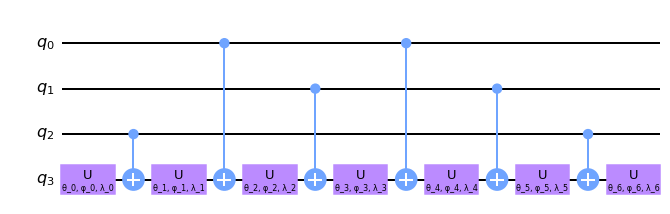

In [983]:
theta_0, phi_0, lam_0 = Parameter('θ_0'), Parameter('φ_0'), Parameter('λ_0')
theta_1, phi_1, lam_1 = Parameter('θ_1'), Parameter('φ_1'), Parameter('λ_1')
theta_2, phi_2, lam_2 = Parameter('θ_2'), Parameter('φ_2'), Parameter('λ_2')
theta_3, phi_3, lam_3 = Parameter('θ_3'), Parameter('φ_3'), Parameter('λ_3')
theta_4, phi_4, lam_4 = Parameter('θ_4'), Parameter('φ_4'), Parameter('λ_4')
theta_5, phi_5, lam_5 = Parameter('θ_5'), Parameter('φ_5'), Parameter('λ_5')
theta_6, phi_6, lam_6 = Parameter('θ_6'), Parameter('φ_6'), Parameter('λ_6')
theta_7, phi_7, lam_7 = Parameter('θ_7'), Parameter('φ_7'), Parameter('λ_7')

theta_0, theta_1, theta_2, theta_3, theta_4, theta_5, theta_6 = angles[0]
phi_0, phi_1, phi_2, phi_3, phi_4, phi_5, phi_6 = angles[1]
lam_0, lam_1, lam_2, lam_3, lam_4, lam_5, lam_6 = angles[2]

circ = q(4)
circ.u(theta_0, phi_0, lam_0, 3)
circ.cx(2, 3)
circ.u(theta_1, phi_1, lam_1, 3)
circ.cx(0, 3)
circ.u(theta_2, phi_2, lam_2, 3)
circ.cx(1, 3)
circ.u(theta_3, phi_3, lam_3, 3)
circ.cx(0, 3)
circ.u(theta_4, phi_4, lam_4, 3)
circ.cx(1, 3)
circ.u(theta_5, phi_5, lam_5, 3)
circ.cx(2, 3)
circ.u(theta_6, phi_6, lam_6, 3)

milk(circ)

#### 1. Forward Propagation

The forward propagation step is defined by

$$\hat{y} = U_{2n} \big{(}\prod_{i=2n-1}^{0} \rho_i U_{i} \big{)} x$$

where $\rho_i = (x_{A[i]} X + (1-x_{A[i]}) I)$

Here we have $4$ different values for $\rho$, coming from $2$ different $\rho$ parameters, one from each input qubit

In [1033]:
angles = np.random.uniform(0, 2*np.pi, (3, 7))

angles = np.array([[np.pi/2, np.pi/2, 0, 0, 0, np.pi/2, np.pi/2],
         [np.pi/4, 0, 0, 0, 0, np.pi/4, 0],
         [np.pi, 3*np.pi/4, np.pi/4, -np.pi/4, np.pi/4, 3*np.pi/4, 3*np.pi/4]])

theta_0, theta_1, theta_2, theta_3, theta_4, theta_5, theta_6 = angles[0]
phi_0, phi_1, phi_2, phi_3, phi_4, phi_5, phi_6 = angles[1]
lam_0, lam_1, lam_2, lam_3, lam_4, lam_5, lam_6 = angles[2]

rho_0 = X
rho_1 = X
rho_2 = X

x = zero

y_hat = y_hat = (U3(angles[0, 6], angles[1, 6], angles[2, 6])@rho_2@U3(angles[0, 5], angles[1, 5], angles[2, 5])@rho_1@
     U3(angles[0, 4], angles[1, 4], angles[2, 4])@rho_0@U3(angles[0, 3], angles[1, 3], angles[2, 3])@rho_1@
     U3(angles[0, 2], angles[1, 2], angles[2, 2])@rho_0@U3(angles[0, 1], angles[1, 1], angles[2, 1])@rho_2@
     U3(angles[0, 0], angles[1, 0], angles[2, 0]))

In [1034]:
view(y_hat)

Matrix([
[   0, 1.0],
[-1.0,   0]])

In [1026]:
get(CnX(3))

Matrix([
[1.0,   0,   0,     0,   0,   0,   0,    0,   0,   0,   0,      0,   0,   0,   0,   0],
[  0, 1.0,   0,     0,   0,   0,   0,    0,   0,   0,   0,      0,   0,   0,   0,   0],
[  0,   0, 1.0,     0,   0,   0,   0,    0,   0,   0,   0,      0,   0,   0,   0,   0],
[  0,   0,   0, 1.0*I,   0,   0,   0,    0,   0,   0,   0,      0,   0,   0,   0,   0],
[  0,   0,   0,     0, 1.0,   0,   0,    0,   0,   0,   0,      0,   0,   0,   0,   0],
[  0,   0,   0,     0,   0, 1.0,   0,    0,   0,   0,   0,      0,   0,   0,   0,   0],
[  0,   0,   0,     0,   0,   0, 1.0,    0,   0,   0,   0,      0,   0,   0,   0,   0],
[  0,   0,   0,     0,   0,   0,   0,    0,   0,   0,   0,      0,   0,   0,   0, 1.0],
[  0,   0,   0,     0,   0,   0,   0,    0, 1.0,   0,   0,      0,   0,   0,   0,   0],
[  0,   0,   0,     0,   0,   0,   0,    0,   0, 1.0,   0,      0,   0,   0,   0,   0],
[  0,   0,   0,     0,   0,   0,   0,    0,   0,   0, 1.0,      0,   0,   0,   0,   0],
[  0,   0,   0,     0, 

#### 2. Calculate Cost

The cost function is defined above as

$$J(w) = 1 - \frac{1}{N} \sum^{N-1}_{j=0}|\langle y^{(j)} | \hat{y}^{(j)} \rangle|^2$$

However, since we are using binary inputs, it's best to perform the gradient descent stochastically. This means that the model will be trained $1$ example at a time. Therefore, the cost function for each iteration will be

$$J(w) = 1 - |\langle y^{(j)} | \hat{y}^{(j)} \rangle|^2$$

The function will take in one prediction $\hat{y}$ and actual value $y$ value each time.

In [1138]:
cost = lambda y, y_hat: 1-np.linalg.norm( np.conj(y).T @ y_hat)**2

#### 3. Backpropagation

Modified to fit with the single matrix parameters search of our example, 

$$\frac{\partial J}{\partial w_0} = -\frac{\text{Re}\big{(} \langle y^{(j)} | \hat{y}^{(j)} \rangle \overbrace{\Big{(} y^{(j)} \cdot \overline{\big{(} \rho_0 \frac{\partial U_{0}}{\partial w_0} x^{(j)} \big{)}} \Big{)}}^{\text{dot product}}\big{)}}{|\langle y^{(j)} | \hat{y}^{(j)} \rangle|}$$

where $\hat{y}$ is previously calculated during the forward propagation step, 

$$\hat{y}^{(j)} = \big{(}\rho_0 U_{0} \big{)} x^{(j)}$$

And the specific derivatives are

\begin{align}
    \frac{\partial U_0}{\partial \theta_0} &= -\frac{1}{2} \begin{bmatrix} s_0 & e^{i\lambda_0} c_0 \\ -e^{i\phi_0}c_0 & e^{i(\phi_0 + \lambda_0)}s_0 \end{bmatrix} \\\\
    \frac{\partial U_0}{\partial \phi_0} &= i \begin{bmatrix} 0 & 0 \\ e^{i\phi_0}s_0 & e^{i(\phi_0 + \lambda_0)}c_0 \end{bmatrix} \\\\
    \frac{\partial U_0}{\partial \lambda_0} &= i \begin{bmatrix} 0 & -e^{i\lambda_0}s_0 \\ 0 & e^{i(\phi_0 + \lambda_0)}c_0 \end{bmatrix} 
\end{align}

To implement this, a general $\frac{\partial J}{\partial w_0}$ function will take in an input for $\frac{\partial U_0}{\partial w_0}$. The specific derivative with respect to each parameters $\theta, \phi, \lambda$ is calculated separately as input to the $\frac{\partial J}{\partial w_0}$ function.

In [567]:
def back_prop(w, epsilon = 1e-7):

    w_plus = U3(theta+epsilon, phi, lam)@x
    w_minus = U3(theta-epsilon, phi, lam)@x

    dtheta = (cost(w_plus, x) - cost(w_minus, x) ) / (2*epsilon)

    w_plus = U3(theta, phi+epsilon, lam)@x
    w_minus = U3(theta, phi-epsilon, lam)@x

    dphi = (cost(w_plus, x) - cost(w_minus, x) ) / (2*epsilon)

    w_plus = U3(theta, phi, lam+epsilon)@x
    w_minus = U3(theta, phi, lam-epsilon)@x

    dlam = (cost(w_plus, x) - cost(w_minus, x) ) / (2*epsilon)
    
    return dtheta, dphi, dlam

#### 4. Parameters Update

In [1078]:
dw = np.zeros((3, 7))

angles = np.random.uniform(0, 2*np.pi, (3, 7))

#angles = np.zeros((3, 7))

y_hat = (U3(angles[0, 6], angles[1, 6], angles[2, 6])@rho_2@U3(angles[0, 5], angles[1, 5], angles[2, 5])@rho_1@
     U3(angles[0, 4], angles[1, 4], angles[2, 4])@rho_0@U3(angles[0, 3], angles[1, 3], angles[2, 3])@rho_1@
     U3(angles[0, 2], angles[1, 2], angles[2, 2])@rho_0@U3(angles[0, 1], angles[1, 1], angles[2, 1])@rho_2@
     U3(angles[0, 0], angles[1, 0], angles[2, 0]))@x

view(y_hat)

### Backpropagation

for i in range(3):
    
    for j in range(7):
        
        angles[i, j] += epsilon

        w_plus = (U3(angles[0, 6], angles[1, 6], angles[2, 6])@rho_2@U3(angles[0, 5], angles[1, 5], angles[2, 5])@rho_1@
             U3(angles[0, 4], angles[1, 4], angles[2, 4])@rho_0@U3(angles[0, 3], angles[1, 3], angles[2, 3])@rho_1@
             U3(angles[0, 2], angles[1, 2], angles[2, 2])@rho_0@U3(angles[0, 1], angles[1, 1], angles[2, 1])@rho_2@
             U3(angles[0, 0], angles[1, 0], angles[2, 0]))@x

        angles[i, j] -= 2*epsilon

        w_minus = (U3(angles[0, 6], angles[1, 6], angles[2, 6])@rho_2@U3(angles[0, 5], angles[1, 5], angles[2, 5])@rho_1@
             U3(angles[0, 4], angles[1, 4], angles[2, 4])@rho_0@U3(angles[0, 3], angles[1, 3], angles[2, 3])@rho_1@
             U3(angles[0, 2], angles[1, 2], angles[2, 2])@rho_0@U3(angles[0, 1], angles[1, 1], angles[2, 1])@rho_2@
             U3(angles[0, 0], angles[1, 0], angles[2, 0]))@x

        dw[i, j] = (cost(w_plus, x) - cost(w_minus, x) ) / (2*epsilon)

        ## Reset angle
        angles[i, j] += epsilon

Matrix([
[0.7005958918 - 0.0971179322*I],
[ 0.143472386 - 0.6922060229*I]])

In [1079]:
epsilon = 1e-7

In [1080]:
view(dw)

Matrix([
[ 0.3174668484,  0.233542381, -0.4619821381, -0.0732028277,  0.1874676592, 0.1440641023,  0.4346707705],
[-0.0585664511, 0.1899804292,  0.0973286385,  0.0495767755, -0.4435615047, 0.1476992395,           0.0],
[          0.0,   0.05856645, -0.1899804281, -0.0973286379, -0.0495767749, 0.4435615031, -0.1476992384]])

In [ ]:
def gradient_descent(w, dw, lr = .001):
    
    if np.all(rho_0 == X) and np.all(rho_1 == X):
        w+=
        
    else:
        theta -= lr*dtheta
        phi -= lr*dphi
        lam -= lr*dlam
    
    return theta, phi, lam

#### 5. Full Implementation

In [1372]:
epsilon = 1e-8

In [1367]:
def train(x, y, w, rho, iterations = 3000, lr = .001):
    
    rho_0, rho_1, rho_2 = rho
    
    y_hat = (U3(w[0, 6], w[1, 6], w[2, 6])@rho_2@U3(w[0, 5], w[1, 5], w[2, 5])@rho_1@
             U3(w[0, 4], w[1, 4], w[2, 4])@rho_0@U3(w[0, 3], w[1, 3], w[2, 3])@rho_1@
             U3(w[0, 2], w[1, 2], w[2, 2])@rho_0@U3(w[0, 1], w[1, 1], w[2, 1])@rho_2@
             U3(w[0, 0], w[1, 0], w[2, 0]))@x
    
    loss = cost(y_hat, y)
    if loss > 1e-9:
        iterations = iterations * 2

    for n in range(iterations):
        
        ### Forward Prop

        dw = np.zeros((3, 7))

        y_hat = (U3(w[0, 6], w[1, 6], w[2, 6])@rho_2@U3(w[0, 5], w[1, 5], w[2, 5])@rho_1@
             U3(w[0, 4], w[1, 4], w[2, 4])@rho_0@U3(w[0, 3], w[1, 3], w[2, 3])@rho_1@
             U3(w[0, 2], w[1, 2], w[2, 2])@rho_0@U3(w[0, 1], w[1, 1], w[2, 1])@rho_2@
             U3(w[0, 0], w[1, 0], w[2, 0]))@x
        
        ### Cost Calculation
        
        if n%500==0:
            loss = cost(y_hat, y)
            print(n, loss)

        ### Backpropagation

        for i in range(3):

            for j in range(7):

                w[i, j] += epsilon

                w_plus = (U3(w[0, 6], w[1, 6], w[2, 6])@rho_2@U3(w[0, 5], w[1, 5], w[2, 5])@rho_1@
                     U3(w[0, 4], w[1, 4], w[2, 4])@rho_0@U3(w[0, 3], w[1, 3], w[2, 3])@rho_1@
                     U3(w[0, 2], w[1, 2], w[2, 2])@rho_0@U3(w[0, 1], w[1, 1], w[2, 1])@rho_2@
                     U3(w[0, 0], w[1, 0], w[2, 0]))@x

                w[i, j] -= 2*epsilon

                w_minus = (U3(w[0, 6], w[1, 6], w[2, 6])@rho_2@U3(w[0, 5], w[1, 5], w[2, 5])@rho_1@
                     U3(w[0, 4], w[1, 4], w[2, 4])@rho_0@U3(w[0, 3], w[1, 3], w[2, 3])@rho_1@
                     U3(w[0, 2], w[1, 2], w[2, 2])@rho_0@U3(w[0, 1], w[1, 1], w[2, 1])@rho_2@
                     U3(w[0, 0], w[1, 0], w[2, 0]))@x

                dw[i, j] = (cost(w_plus, x) - cost(w_minus, x) ) / (2*epsilon)

                ## Reset angle
                w[i, j] += epsilon
                
        ### Gradient Descent
        
        if np.all(rho_0 == X) and np.all(rho_1 == X) and np.all(rho_2 == X):
            w += lr*dw
        else:
            w -=lr*dw
        
    print(n, cost(y_hat, y))
    print('\n')
        
    return w

In [1273]:
w = np.random.uniform(0, 2*np.pi, (3, 7))
w

array([[0.78553336, 3.42558797, 4.03626615, 0.11116591, 5.41423953,
        0.44877595, 2.42345252],
       [2.45383833, 1.83592716, 1.73416383, 0.44462308, 4.49801751,
        2.08868088, 3.97924714],
       [2.37674794, 4.75212927, 0.3558813 , 5.6772001 , 6.2028194 ,
        6.13862121, 0.82873749]])

In [1373]:
    ### Random Initialization

# w = np.ones((3, 7))
    
    for _ in range(200):

        x = one
        y = one

        for rho in list(product([I, X], [I, X], [I, X]))[:7]:

            w = train(x, y, w, rho = rho, iterations = 10)

        # Special Case

        rho = (X, X, X)
        x = one
        y = zero
        w = train(x, y, w, rho = rho, iterations = 20)

        x = zero
        y = zero

        for rho in list(product([I, X], [I, X], [I, X]))[:7]:

            w = train(x, y, w, rho = rho, iterations = 10)

        # Special Case

        rho = (X, X, X)
        x = zero
        y = one
        w = train(x, y, w, rho = rho, iterations = 20)

0 1.397001181402402e-09
19 1.273643412957881e-09


0 1.7933954321591727e-09
19 1.5519117102513746e-09


0 3.887006272407234e-09
19 3.4544349603038427e-09


0 1.6607628605669333e-09
19 1.4706631468186515e-09


0 8.257670103262171e-10
9 7.853884209652051e-10


0 7.30668858750505e-10
9 6.900306992463356e-10


0 1.901388602121301e-09
19 1.6955705728349812e-09


0 5.776492617570739e-09
39 4.508398321334539e-09


0 9.996019567637404e-10
9 9.567910908003796e-10


0 1.3296592715761335e-09
19 1.151177597691344e-09


0 3.3735692017700103e-09
19 2.994553494062302e-09


0 1.5159711264089992e-09
19 1.3443979263172423e-09


0 6.384259787495239e-10
9 6.066596114351341e-10


0 6.003495478523746e-10
9 5.679472447894796e-10


0 1.7468706481338359e-09
19 1.5587420243434735e-09


0 4.689622246090153e-09
39 3.673274351356781e-09


0 7.631377751948776e-10
9 7.304621352233198e-10


0 1.0006793171868367e-09
19 8.667961903796595e-10


0 2.95256086246809e-09
19 2.618264494103073e-09


0 1.393790416415186e-09
19

9 5.023756965982784e-10


0 3.185769426039542e-10
9 3.01330738139427e-10


0 1.8115131616980307e-10
9 1.7178791722471942e-10


0 6.212197423138832e-10
9 5.905362865377128e-10


0 5.992513152364154e-10
19 5.353926191276059e-10


0 7.83511033830564e-11
9 7.476286256746789e-11


0 9.902478836920636e-11
9 9.224776498228948e-11


0 6.710612066029853e-10
9 6.327662838145898e-10


0 5.097247068874822e-10
9 4.811577802854572e-10


0 3.094882128351628e-10
9 2.927453834900007e-10


0 1.7268875218690027e-10
9 1.6376966449627162e-10


0 5.954541304475924e-10
9 5.660916180261211e-10


0 5.692424309700073e-10
19 5.085794008152789e-10


0 7.611555830067118e-11
9 7.260925194430001e-11


0 9.270406664541042e-11
9 8.634160053588857e-11


0 6.439617727949098e-10
9 6.072133906798172e-10


0 4.88183715674495e-10
9 4.6082049287576865e-10


0 3.0087243807486175e-10
9 2.845907953741289e-10


0 1.6484968945462697e-10
9 1.5635581718242975e-10


0 5.709754891114471e-10
9 5.428717475552958e-10


0 5.4071724875370

19 1.9451507071721608e-10


0 5.5718984981467656e-11
9 5.2944759687534315e-11


0 3.2654323689484954e-11
9 3.035349749325178e-11


0 3.164488671103527e-10
9 2.9845526050564786e-10


0 2.1892043733373612e-10
9 2.0662227484535833e-10


0 1.8472534613067637e-10
9 1.74798397978293e-10


0 8.385048211323465e-11
9 7.950817781932074e-11


0 2.7259106083477036e-10
9 2.594735537542192e-10


0 2.0722468185851994e-10
19 1.850803954539515e-10


0 5.495182087145167e-11
9 5.221023613444231e-11


0 3.108913126936841e-11
9 2.8897328974153424e-11


0 3.0579916376893834e-10
9 2.88420176630666e-10


0 2.1026669294599287e-10
9 1.984539199639812e-10


0 1.802822335861265e-10
9 1.7059531565166708e-10


0 8.160672138046721e-11
9 7.737188667533701e-11


0 2.6304447509062356e-10
9 2.5039192941278543e-10


0 1.9719759158931538e-10
19 1.7612356018048558e-10


0 5.4190207876558816e-11
9 5.1480819607263584e-11


0 2.9608759888333225e-11
9 2.752376104808718e-11


0 2.955726774445111e-10
9 2.7877633534956203e-10


0

9 9.639666842531369e-11


0 1.1462231164216519e-10
9 1.0847367448718614e-10


0 5.235900601974208e-11
9 4.954014976021881e-11


0 1.4275181037248785e-10
9 1.359199419681545e-10


0 7.899192411287004e-11
19 7.052181061339979e-11


0 4.040745515965227e-11
9 3.835198825186126e-11


0 1.22299947946658e-11
9 1.1364686969272952e-11


0 1.6161427751626434e-10
9 1.525020110193509e-10


0 9.854406179954367e-11
9 9.303202652688469e-11


0 1.1198930671696417e-10
9 1.0598300015374207e-10


0 5.1269433143374954e-11
9 4.850253532140414e-11


0 1.3872658577440689e-10
9 1.320870079979386e-10


0 7.53777040785053e-11
19 6.729394819160461e-11


0 3.972067119661915e-11
9 3.770117551482599e-11


0 1.1689760270883198e-11
9 1.0862644117537457e-11


0 1.5688028653926267e-10
9 1.480355837912839e-10


0 9.512102217001939e-11
9 8.980416410508951e-11


0 1.0942979855599333e-10
9 1.035642682722937e-10


0 5.0203619039734804e-11
9 4.7488235566106596e-11


0 1.348643419163409e-10
9 1.2840706276051606e-10


0 7.1938

19 2.85511614350753e-11


0 2.8201885271528226e-11
9 2.6760149651749998e-11


0 5.151656878865651e-12
9 4.793720975726501e-12


0 9.176059911908396e-11
9 8.662204287190889e-11


0 5.061817631712984e-11
9 4.7799764146816415e-11


0 7.089373532664922e-11
9 6.709655053782626e-11


0 3.382671920348912e-11
9 3.1939340061626353e-11


0 8.360201420032354e-11
9 7.955680558779932e-11


0 3.0643265702678946e-11
19 2.734057424902403e-11


0 2.7679192271534703e-11
9 2.6266544495001654e-11


0 4.9469317531247725e-12
9 4.600986258651574e-12


0 8.93276563829204e-11
9 8.432898823684809e-11


0 4.906475226107432e-11
9 4.633693428957031e-11


0 6.933076335258193e-11
9 6.561395871074183e-11


0 3.3132385723888547e-11
9 3.1283198254072886e-11


0 8.175327081971773e-11
9 7.779621391534874e-11


0 2.933320253362126e-11
19 2.617106531488389e-11


0 2.715339064707223e-11
9 2.5765389821685858e-11


0 4.741984582778969e-12
9 4.413580612094847e-12


0 8.698575193477609e-11
9 8.21158696595603e-11


0 4.757150229

9 2.6544544340367793e-11


0 4.5671688653214915e-11
9 4.322475710694107e-11


0 2.2198021198960305e-11
9 2.0936363753776277e-11


0 5.541500591732529e-11
9 5.268896430266068e-11


0 1.3250511798901243e-11
19 1.1815881606480616e-11


0 1.8793633316249725e-11
9 1.7834178578368665e-11


0 2.2744028882470957e-12
9 2.121414155453749e-12


0 5.3542281719387574e-11
9 5.056444152273798e-11


0 2.7329249974172853e-11
9 2.5818680526867865e-11


0 4.46975789714088e-11
9 4.2299941327428314e-11


0 2.1725732324284763e-11
9 2.049249658853114e-11


0 5.437938987995494e-11
9 5.1700643766139365e-11


0 1.2724710174438769e-11
19 1.134603522245925e-11


0 1.8420154290765822e-11
9 1.7482015834957565e-11


0 2.192468429029759e-12
9 2.043920588334913e-12


0 5.225064825253867e-11
9 4.934519459709463e-11


0 2.6591839841216824e-11
9 2.5121016378193417e-11


0 4.375122486521832e-11
9 4.140465748037059e-11


0 2.1268986571953974e-11
9 2.006039778734703e-11


0 5.3365312169262324e-11
9 5.0733639511690853e-11




9 1.3563816736450462e-11


0 3.864109032747365e-11
9 3.6707081818576626e-11


0 6.118217044104313e-12
19 5.452527318539069e-12


0 1.2644107982850983e-11
9 1.1998402271728992e-11


0 1.170175067954915e-12
9 1.0955680807001045e-12


0 3.3258507059485964e-11
9 3.1416425017027905e-11


0 1.612554534347055e-11
9 1.5236034656140873e-11


0 2.919864350303669e-11
9 2.763322903831522e-11


0 1.407518546159281e-11
9 1.3268719456505096e-11


0 3.7977621047957655e-11
9 3.6076031051379687e-11


0 5.897948796018682e-12
19 5.255351709365641e-12


0 1.2398304605198973e-11
9 1.1765699525767559e-11


0 1.1364242880063102e-12
9 1.0651479698253752e-12


0 3.249689406459311e-11
9 3.069811072009543e-11


0 1.5724088697766092e-11
9 1.4856560426323995e-11


0 2.8588464928702706e-11
9 2.705724533313969e-11


0 1.3767653683771641e-11
9 1.297895124707793e-11


0 3.732902875697164e-11
9 3.54587470496881e-11


0 5.6843418860808015e-12
19 5.065059482944889e-12


0 1.215849643187994e-11
9 1.1537659716509552e-11


0

9 8.065992318506687e-12


0 6.774580896262705e-13
9 6.366018823200648e-13


0 2.1205481814945415e-11
9 2.0035972880805275e-11


0 9.92406157251935e-12
9 9.380274335057948e-12


0 1.9308332710465947e-11
9 1.8272050539280826e-11


0 9.072964601841704e-12
9 8.554268404736831e-12


0 2.698841150561293e-11
9 2.5619062427040262e-11


0 2.8914648453337577e-12
19 2.575051283315588e-12


0 8.326894729293599e-12
9 7.903455667701564e-12


0 6.59472476627343e-13
9 6.186162693211372e-13


0 2.0752288776293426e-11
9 1.9609203150139365e-11


0 9.698908343125368e-12
9 9.167111514329918e-12


0 1.8923751454735793e-11
9 1.7907453297993925e-11


0 8.878231483322452e-12
9 8.37108160567368e-12


0 2.6530111441047666e-11
9 2.51829668229675e-11


0 2.7911006839076435e-12
19 2.4857893521357255e-12


0 8.15969514178505e-12
9 7.744027641365392e-12


0 6.410427744185654e-13
9 6.032951915813101e-13


0 2.0307311388023663e-11
9 1.9186430222362105e-11


0 9.475087381360936e-12
9 8.954392782811738e-12


0 1.85396142

9 1.3032241952259938e-11


0 6.302514066192089e-12
9 5.957234705533665e-12


0 1.2889689315898067e-11
9 1.219691014853197e-11


0 5.8475446707006995e-12
9 5.5138116294983774e-12


0 1.922817460808801e-11
9 1.8243184740640572e-11


0 1.4952483695651608e-12
19 1.3307133173157126e-12


0 5.593525642666464e-12
9 5.3084203699427235e-12


0 4.169997680492088e-13
9 3.930189507173054e-13


0 1.3501644247071454e-11
9 1.2758682998992299e-11


0 6.165290500348419e-12
9 5.8260063440229715e-12


0 1.2633227797209656e-11
9 1.1955769707583386e-11


0 5.721867424313132e-12
9 5.394573676653636e-12


0 1.890598788634179e-11
9 1.7938317498078504e-11


0 1.4506174039752295e-12
19 1.2916334668489071e-12


0 5.486722187697524e-12
9 5.206945985491984e-12


0 4.0900616227190767e-13
9 3.852473895449293e-13


0 1.3218759420396964e-11
9 1.2491119250057636e-11


0 6.029621246739225e-12
9 5.700107053030479e-12


0 1.2386980330347797e-11
9 1.1721512649387478e-11


0 5.598410623974814e-12
9 5.278888437487694e-12


0

9 8.193890010943505e-12


0 3.786082558576709e-12
9 3.5698111133797283e-12


0 1.36493039093466e-11
9 1.2946532734758875e-11


0 8.144596108650148e-13
19 7.260858581048524e-13


0 3.775202372935382e-12
9 3.5849101465146305e-12


0 2.822186928597148e-13
9 2.6623148130511254e-13


0 8.894662784086904e-12
9 8.406164653251835e-12


0 3.993916308786538e-12
9 3.774758283725532e-12


0 8.490985692333197e-12
9 8.035794252236883e-12


0 3.7054803669889225e-12
9 3.495426170729843e-12


0 1.3413936628126066e-11
9 1.2722267683784594e-11


0 7.900347043232614e-13
19 7.034373084024992e-13


0 3.6985969842362465e-12
9 3.50985907004997e-12


0 2.7622348852673895e-13
9 2.6068036618198676e-13


0 8.713474386468079e-12
9 8.234968262854636e-12


0 3.910427537334726e-12
9 3.694378136742671e-12


0 8.326006550873899e-12
9 7.879474850369661e-12


0 3.6268765768454614e-12
9 3.4199310050553322e-12


0 1.3187451131102534e-11
9 1.2507328506217164e-11


0 7.689404668553834e-13
19 6.850076061937216e-13


0 3.62843

19 4.1588954502458364e-13


0 2.5641710976742615e-12
9 2.4349411376078933e-12


0 1.9939605522267811e-13
9 1.8918200339612667e-13


0 5.902167643512257e-12
9 5.578870698741412e-12


0 2.6141311337823936e-12
9 2.4706903190008234e-12


0 5.723643781152532e-12
9 5.415667914121514e-12


0 2.4131807663252403e-12
9 2.277733557320971e-12


0 9.463985151114684e-12
9 8.972378395810665e-12


0 4.5341508325691393e-13
19 4.030109579389318e-13


0 2.5131008385415043e-12
9 2.3854251907096113e-12


0 1.9473311851925246e-13
9 1.8451906669270102e-13


0 5.787148538161091e-12
9 5.470512931537996e-12


0 2.561062473205311e-12
9 2.4209523274976164e-12


0 5.6139537463195666e-12
9 5.311973083621524e-12


0 2.3638868640318833e-12
9 2.2302160118670145e-12


0 9.297895786630761e-12
9 8.817391261572993e-12


0 4.418687638008123e-13
19 3.936850845320805e-13


0 2.4658053376924727e-12
9 2.3419044481443052e-12


0 1.9229062786507711e-13
9 1.816324868286756e-13


0 5.67146329899515e-12
9 5.361266985914881e-12


0 

KeyboardInterrupt: 

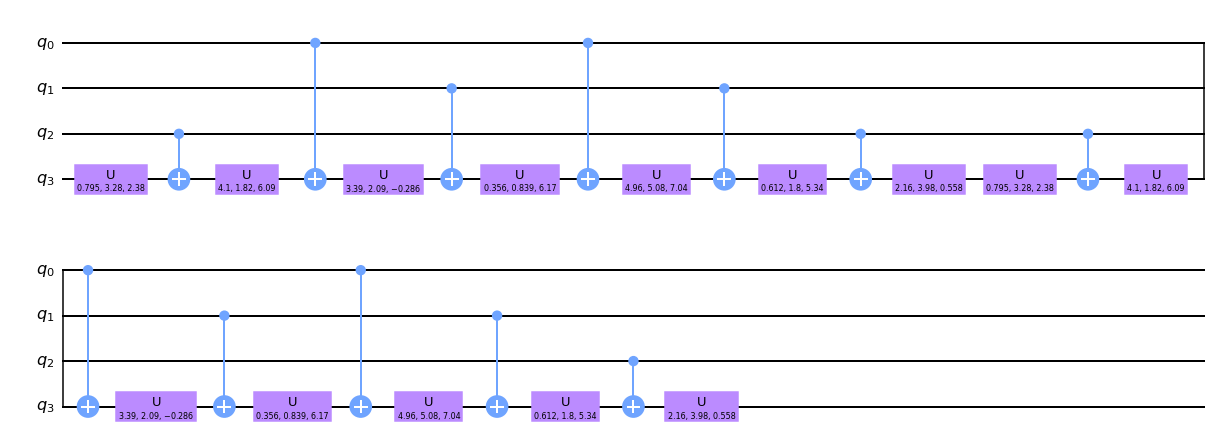

In [1374]:
theta_0, theta_1, theta_2, theta_3, theta_4, theta_5, theta_6 = w[0]
phi_0, phi_1, phi_2, phi_3, phi_4, phi_5, phi_6 = w[1]
lam_0, lam_1, lam_2, lam_3, lam_4, lam_5, lam_6 = w[2]

circ = q(4)
circ.u(theta_0, phi_0, lam_0, 3)
circ.cx(2, 3)
circ.u(theta_1, phi_1, lam_1, 3)
circ.cx(0, 3)
circ.u(theta_2, phi_2, lam_2, 3)
circ.cx(1, 3)
circ.u(theta_3, phi_3, lam_3, 3)
circ.cx(0, 3)
circ.u(theta_4, phi_4, lam_4, 3)
circ.cx(1, 3)
circ.u(theta_5, phi_5, lam_5, 3)
circ.cx(2, 3)
circ.u(theta_6, phi_6, lam_6, 3)

circ.u(theta_0, phi_0, lam_0, 3)
circ.cx(2, 3)
circ.u(theta_1, phi_1, lam_1, 3)
circ.cx(0, 3)
circ.u(theta_2, phi_2, lam_2, 3)
circ.cx(1, 3)
circ.u(theta_3, phi_3, lam_3, 3)
circ.cx(0, 3)
circ.u(theta_4, phi_4, lam_4, 3)
circ.cx(1, 3)
circ.u(theta_5, phi_5, lam_5, 3)
circ.cx(2, 3)
circ.u(theta_6, phi_6, lam_6, 3)

milk(circ)

In [1375]:
get(circ)

Matrix([
[-0.9931438541 + 0.1168986098*I,                              0,                              0,                             0,                              0,                             0,                             0,                             0,         2.6686e-6 + 7.841e-7*I,                              0,                              0,                             0,                             0,                              0,                              0,                             0],
[                             0, -0.9931440129 + 0.1168972613*I,                              0,                             0,                              0,                             0,                             0,                             0,                              0,         -4.0754e-6 - 1.29e-8*I,                              0,                             0,                             0,                              0,                              0,          

In [1376]:
view(np.abs(get(circ, nice = False)))

Matrix([
[      1.0,       0.0,       0.0,      0.0,      0.0,       0.0,       0.0,      0.0, 2.7814e-6,       0.0,       0.0,      0.0,      0.0,       0.0,       0.0,      0.0],
[      0.0,       1.0,       0.0,      0.0,      0.0,       0.0,       0.0,      0.0,       0.0, 4.0754e-6,       0.0,      0.0,      0.0,       0.0,       0.0,      0.0],
[      0.0,       0.0,       1.0,      0.0,      0.0,       0.0,       0.0,      0.0,       0.0,       0.0, 4.2548e-6,      0.0,      0.0,       0.0,       0.0,      0.0],
[      0.0,       0.0,       0.0,      1.0,      0.0,       0.0,       0.0,      0.0,       0.0,       0.0,       0.0, 1.561e-6,      0.0,       0.0,       0.0,      0.0],
[      0.0,       0.0,       0.0,      0.0,      1.0,       0.0,       0.0,      0.0,       0.0,       0.0,       0.0,      0.0, 7.976e-7,       0.0,       0.0,      0.0],
[      0.0,       0.0,       0.0,      0.0,      0.0,       1.0,       0.0,      0.0,       0.0,       0.0,       0.0,      0.0,   

In [1377]:
w

array([[ 0.7952063 ,  4.10229249,  3.38665787,  0.35578696,  4.96205657,
         0.61213575,  2.15571346],
       [ 3.28074444,  1.8162113 ,  2.0909485 ,  0.83884749,  5.07758891,
         1.80388818,  3.97921253],
       [ 2.37666272,  6.08597814, -0.28560549,  6.16905114,  7.04262853,
         5.34294325,  0.55841543]])

In [1360]:
w[0]/np.pi

array([0.25311894, 1.30579004, 1.07800176, 0.11324999, 1.57944392,
       0.19480645, 0.68619731])

In [1361]:
w[1]/np.pi

array([1.04426868, 0.57808598, 0.66556599, 0.26704078, 1.61624163,
       0.57425422, 1.26663364])

In [1362]:
w[2]/np.pi

array([ 0.75654245,  1.93725667, -0.09091327,  1.96364475,  2.24174931,
        1.70067196,  0.17773533])

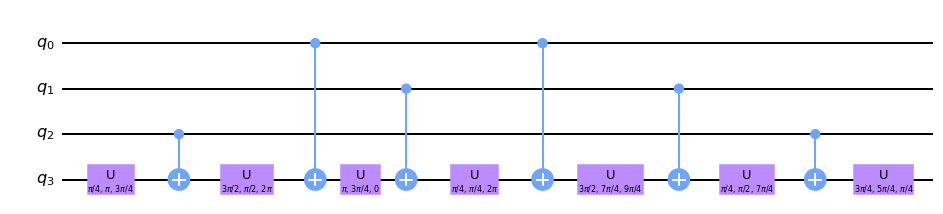

In [1345]:
w_test = np.array([[.25, 1.5, 1, .25, 1.5, .25, .75], 
                   [1, .5, .75, .25, 1.75, .5, 1.25], 
                   [.75, 2, 0, 2, 2.25, 1.75, .25]])*np.pi

theta_0, theta_1, theta_2, theta_3, theta_4, theta_5, theta_6 = w_test[0]
phi_0, phi_1, phi_2, phi_3, phi_4, phi_5, phi_6 = w_test[1]
lam_0, lam_1, lam_2, lam_3, lam_4, lam_5, lam_6 = w_test[2]

circ = q(4)
circ.u(theta_0, phi_0, lam_0, 3)
circ.cx(2, 3)
circ.u(theta_1, phi_1, lam_1, 3)
circ.cx(0, 3)
circ.u(theta_2, phi_2, lam_2, 3)
circ.cx(1, 3)
circ.u(theta_3, phi_3, lam_3, 3)
circ.cx(0, 3)
circ.u(theta_4, phi_4, lam_4, 3)
circ.cx(1, 3)
circ.u(theta_5, phi_5, lam_5, 3)
circ.cx(2, 3)
circ.u(theta_6, phi_6, lam_6, 3)

milk(circ)

In [1346]:
view(np.abs(get(circ, nice = False)))

Matrix([
[0.9682458366,          0.0,          0.0, 0.0,          0.0,          0.0,          0.0,          0.0,         0.25,          0.0,          0.0, 0.0,          0.0,          0.0,          0.0,          0.0],
[         0.0, 0.9013878189,          0.0, 0.0,          0.0,          0.0,          0.0,          0.0,          0.0, 0.4330127019,          0.0, 0.0,          0.0,          0.0,          0.0,          0.0],
[         0.0,          0.0, 0.9682458366, 0.0,          0.0,          0.0,          0.0,          0.0,          0.0,          0.0,         0.25, 0.0,          0.0,          0.0,          0.0,          0.0],
[         0.0,          0.0,          0.0, 1.0,          0.0,          0.0,          0.0,          0.0,          0.0,          0.0,          0.0, 0.0,          0.0,          0.0,          0.0,          0.0],
[         0.0,          0.0,          0.0, 0.0, 0.8291561976,          0.0,          0.0,          0.0,          0.0,          0.0,          0.0, 0.0, 0.559016

In [1437]:
def CnH(n, control_list=None, target=None, circ=None, theta=1):
    # Build New Circuit
    if circ == None:
        circ = q(n + 1)
        control_list = list(range(n))
        target = n

    # Base Case

    if n == 1 and theta == 1:
        circ.ch(control_list, target)

        return circ

    if n == 1:
        circ.unitary(cu_matrix(2, 0, 1, Hp(1 / theta)), [control_list, target])

        return circ

        # New Case

    # CH
    circ.unitary(cu_matrix(2, 0, 1, Hp(1 / (theta * 2))), [control_list[-1], target])

    # C(n-1)X
    circ = CnX(n - 1, control_list[:-1], control_list[-1], circ)

    # CH
    circ.unitary(cu_matrix(2, 0, 1, Hp(-1 / (theta * 2))), [control_list[-1], target])

    # C(n-1)X
    circ = CnX(n - 1, control_list[:-1], control_list[-1], circ)

    # C(n-1)P
    circ = CnH(n - 1, control_list[:-1], target, circ, theta * 2)

    return circ


def h_relief(n, no_h, return_circ=False):
    # n is the number of control qubit
    # no_h is the number of control qubit on the side hadamard
    circ = q(n + 1)
    circ = CnH(no_h, list(range(no_h)), n, circ)

    circ = CnP(n - no_h, list(range(no_h, n)), n, circ)
    circ = CnH(no_h, list(range(no_h)), n, circ)

    '''# Test for accuracy
    test = get(circ, nice = False)
    unitary_check(test)'''

    if return_circ:
        return circ

    dtp(circ, nice=False)

In [1384]:
def CnX(n, control_list = None, target = None, circ = None, theta = 1):
    
    # Build New Circuit
    if circ == None:
        circ = q(n+1)
        control_list = list(range(n))
        target = n
    
    # Base Case
    if n == 1:
        
        circ.cx(*control_list, target)
        
        return circ
    
    if n==2:
        circ.ch(control_list[0], target)
        circ.cz(control_list[1], target)
        circ.ch(control_list[0], target)
        
        return circ
    
    if n == 3:
        theta_0, theta_1, theta_2, theta_3, theta_4, theta_5, theta_6 = w[0]
        phi_0, phi_1, phi_2, phi_3, phi_4, phi_5, phi_6 = w[1]
        lam_0, lam_1, lam_2, lam_3, lam_4, lam_5, lam_6 = w[2]

        circ.u(theta_0, phi_0, lam_0, target)
        circ.cx(control_list[2], target)
        circ.u(theta_1, phi_1, lam_1, target)
        circ.cx(control_list[0], target)
        circ.u(theta_2, phi_2, lam_2, target)
        circ.cx(control_list[1], target)
        circ.u(theta_3, phi_3, lam_3, target)
        circ.cx(control_list[0], target)
        circ.u(theta_4, phi_4, lam_4, target)
        circ.cx(control_list[1], target)
        circ.u(theta_5, phi_5, lam_5, target)
        circ.cx(control_list[2], target)
        circ.u(theta_6, phi_6, lam_6, target)
        
        return circ
    
    if n==4:
        circ.ch(control_list[0], target)
        circ.p(np.pi/8, control_list[1])
        circ.cx(control_list[1], control_list[2])
        circ.p(-np.pi/8, control_list[2])
        circ.cx(control_list[1], control_list[2])
        circ.p(np.pi/8, control_list[2])
        circ.cx(control_list[2], control_list[3])
        circ.p(-np.pi/8, control_list[3])
        circ.cx(control_list[1], control_list[3])
        circ.p(np.pi/8, control_list[3])
        circ.cx(control_list[2], control_list[3])
        circ.p(-np.pi/8, control_list[3])
        circ.cx(control_list[1], control_list[3])
        circ.p(np.pi/8, control_list[3])
        circ.cx(control_list[3], target)
        circ.p(-np.pi/8, target)
        circ.cx(control_list[1], target)
        circ.p(np.pi/8, target)
        circ.cx(control_list[2], target)
        circ.p(-np.pi/8, target)
        circ.cx(control_list[1], target)
        circ.p(np.pi/8, target)
        circ.cx(control_list[3], target)
        circ.p(-np.pi/8, target)
        circ.cx(control_list[1], target)
        circ.p(np.pi/8, target)
        circ.cx(control_list[2], target)
        circ.p(-np.pi/8, target)
        circ.cx(control_list[1], target)
        circ.p(np.pi/8, target)
        circ.ch(control_list[0], target)
        
        return circ
        
    
    # New Case
    
    # CH
    circ.ch(control_list[0], target)
    
    # CnP
    circ = CnP(n-1, control_list[1:], target, circ, theta)
    
    # CH
    circ.ch(control_list[0], target)
    
    return circ

def CnP(n, control_list = None, target = None, circ = None, theta = 1):
    
    # Build New Circuit
    if circ == None:
        circ = q(n+1)
        control_list = list(range(n))
        target = n
    
    # Base Case
        
    if n == 1:
        circ = control_phase(circ, theta, control_list, target)
        
        return circ 
    
    if n==2:
        circ.p(np.pi/(theta*(2**n)), control_list[0])
        circ.cx(control_list[0], control_list[1])
        circ.p(-np.pi/(theta*2**n), control_list[1])
        circ.cx(control_list[0], control_list[1])
        circ.p(np.pi/(theta*2**n), control_list[1])
        circ.cx(control_list[1], target)
        circ.p(-np.pi/(theta*2**n), target)
        circ.cx(control_list[0], target)
        circ.p(np.pi/(theta*2**n), target)
        circ.cx(control_list[1], target)
        circ.p(-np.pi/(theta*2**n), target)
        circ.cx(control_list[0], target)
        circ.p(np.pi/(theta*2**n), target)

        return circ

    if n==3:
        circ.p(np.pi/(theta*2**n), control_list[0])
        circ.cx(control_list[0], control_list[1])
        circ.p(-np.pi/(theta*2**n), control_list[1])
        circ.cx(control_list[0], control_list[1])
        circ.p(np.pi/(theta*2**n), control_list[1])
        circ.cx(control_list[1], control_list[2])
        circ.p(-np.pi/(theta*2**n), control_list[2])
        circ.cx(control_list[0], control_list[2])
        circ.p(np.pi/(theta*2**n), control_list[2])
        circ.cx(control_list[1], control_list[2])
        circ.p(-np.pi/(theta*2**n), control_list[2])
        circ.cx(control_list[0], control_list[2])
        circ.p(np.pi/(theta*2**n), control_list[2])
        circ.cx(control_list[0], target)
        circ.p(-np.pi/(theta*2**n), target)
        circ.cx(control_list[1], target)
        circ.p(np.pi/(theta*2**n), target)
        circ.cx(control_list[2], target)
        circ.p(-np.pi/(theta*2**n), target)
        circ.cx(control_list[1], target)
        circ.p(np.pi/(theta*2**n), target)
        circ.cx(control_list[0], target)
        circ.p(-np.pi/(theta*2**n), target)
        circ.cx(control_list[1], target)
        circ.p(np.pi/(theta*2**n), target)
        circ.cx(control_list[2], target)
        circ.p(-np.pi/(theta*2**n), target)
        circ.cx(control_list[1], target)
        circ.p(np.pi/(theta*2**n), target)

        return circ
        
    
    # New Case
    
    # CP
    circ = control_phase(circ, theta*2, control_list[-1], target)
    
    # C(n-1)X
    circ = CnX(n-1, control_list[:-1], control_list[-1], circ)
    
    # -CP
    circ = control_phase(circ, -theta*2, control_list[-1], target)
    
    # C(n-1)X
    circ = CnX(n-1, control_list[:-1], control_list[-1], circ)
    
    # C(n-1)P
    circ = CnP(n-1, control_list[:-1], target, circ, theta*2)
    
    return circ



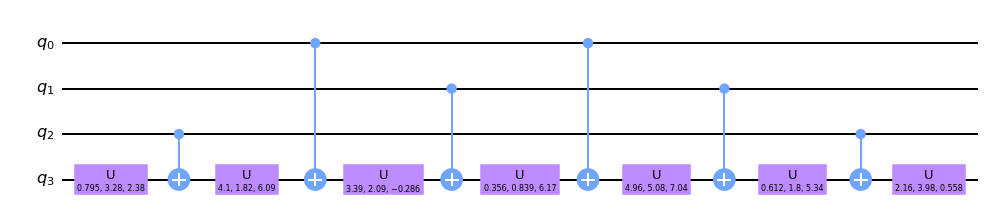

In [1385]:
circ = CnX(3)

milk(circ)

In [1426]:
circ = CnX(8)

a = np.round(np.abs(get(circ, nice = False)), 5)

a = np.abs(get(circ, nice = False))

In [1410]:
cx_check(a)

Unitary is correct


In [1405]:
a.shape

(128, 128)

In [1445]:
n = 8

circ = CnX(n)

a = np.round(np.abs(get(circ, nice = False)), 5)

a = np.abs(get(circ, nice = False))

size = 2**(n+1)

cx_theory = np.identity(size)

# Change all the difference
cx_theory[int(size / 2) - 1, size - 1] = 1
cx_theory[size - 1, int(size / 2) - 1] = 1
cx_theory[int(size / 2) - 1, int(size / 2) - 1] = 0
cx_theory[size - 1, size - 1] = 0

In [1446]:
np.sum(a- cx_theory)

0.003808753344665161

In [1447]:
circ = h_relief(8, 2, return_circ = True)

In [1448]:
# a = np.round(np.abs(get(circ, nice = False)), 5)

a = np.abs(get(circ, nice = False))

size = 2**(9)

cx_theory = np.identity(size)

# Change all the difference
cx_theory[int(size / 2) - 1, size - 1] = 1
cx_theory[size - 1, int(size / 2) - 1] = 1
cx_theory[int(size / 2) - 1, int(size / 2) - 1] = 0
cx_theory[size - 1, size - 1] = 0

In [1449]:
np.sum(a- cx_theory)

0.003390114051089576

In [1450]:
w

array([[ 0.7952063 ,  4.10229249,  3.38665787,  0.35578696,  4.96205657,
         0.61213575,  2.15571346],
       [ 3.28074444,  1.8162113 ,  2.0909485 ,  0.83884749,  5.07758891,
         1.80388818,  3.97921253],
       [ 2.37666272,  6.08597814, -0.28560549,  6.16905114,  7.04262853,
         5.34294325,  0.55841543]])